Dataset preparation and Model training

In [ ]:
import cv2 as cv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from google.colab.patches import cv2_imshow as cv_imshow

# Step 1: Load the dataset
from scipy.io import arff
data = arff.loadarff('Rice_Cammeo_Osmancik.arff')

df = pd.DataFrame(data[0])
df['Class'] = df['Class'].str.decode('utf-8')
df.head()


# Step 2: Preprocess the data
# Encode the target variable
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])  # 0 = Cammeo, 1 = Osmancik

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(max_iter=500)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Classification Report": report,
        "ROC AUC": roc_auc
    }

# Display results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Classification Report:\n{metrics['Classification Report']}")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print("-" * 50)


Model: Logistic Regression
Accuracy: 0.9291338582677166
Classification Report:
              precision    recall  f1-score   support

      Cammeo       0.92      0.93      0.92       350
    Osmancik       0.94      0.93      0.93       412

    accuracy                           0.93       762
   macro avg       0.93      0.93      0.93       762
weighted avg       0.93      0.93      0.93       762

ROC AUC: 0.982246879334258
--------------------------------------------------
Model: SVM (Linear Kernel)
Accuracy: 0.9291338582677166
Classification Report:
              precision    recall  f1-score   support

      Cammeo       0.92      0.93      0.92       350
    Osmancik       0.94      0.93      0.93       412

    accuracy                           0.93       762
   macro avg       0.93      0.93      0.93       762
weighted avg       0.93      0.93      0.93       762

ROC AUC: 0.9822676837725381
--------------------------------------------------
Model: SVM (RBF Kernel)
Accurac

Feature Importance Classification

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

# Step 1: Feature Importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Feature Importance:")
print(feature_importances)

# Step 2: Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=5, step=1)
rfe_selector.fit(X_train, y_train)

selected_features = X.columns[rfe_selector.support_]
print("Selected Features from RFE:", list(selected_features))

# Step 3: Train models with selected features (if applicable)
X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)


Feature Importance:
             Feature  Importance
2  Major_Axis_Length    0.290676
1          Perimeter    0.255485
0               Area    0.162801
5        Convex_Area    0.129339
4       Eccentricity    0.087073
3  Minor_Axis_Length    0.040020
6             Extent    0.034607
Selected Features from RFE: ['Area', 'Perimeter', 'Major_Axis_Length', 'Eccentricity', 'Convex_Area']


Hyperparameter Tuning for Models

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Dictionary to store tuned models and their parameters
tuned_models = {}

# Step 1: Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=500, random_state=42),
    param_grid=param_grid_lr,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)
tuned_models['Logistic Regression'] = grid_search_lr.best_estimator_
print("Best Params for Logistic Regression:", grid_search_lr.best_params_)

# Step 2: SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_svm.fit(X_train, y_train)
tuned_models['SVM'] = grid_search_svm.best_estimator_
print("Best Params for SVM:", grid_search_svm.best_params_)

# Step 3: Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_dt.fit(X_train, y_train)
tuned_models['Decision Tree'] = grid_search_dt.best_estimator_
print("Best Params for Decision Tree:", grid_search_dt.best_params_)

# Step 4: Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
tuned_models['Random Forest'] = grid_search_rf.best_estimator_
print("Best Params for Random Forest:", grid_search_rf.best_params_)

# Step 5: Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_gb = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_gb.fit(X_train, y_train)
tuned_models['Gradient Boosting'] = grid_search_gb.best_estimator_
print("Best Params for Gradient Boosting:", grid_search_gb.best_params_)


# Step 6: K-Nearest Neighbors (KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search_knn.fit(X_train, y_train)
tuned_models['KNN'] = grid_search_knn.best_estimator_
print("Best Params for KNN:", grid_search_knn.best_params_)

# Step 7: Neural Network
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
}
grid_search_nn = GridSearchCV(
    estimator=MLPClassifier(max_iter=500, random_state=42),
    param_grid=param_grid_nn,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search_nn.fit(X_train, y_train)
tuned_models['Neural Network'] = grid_search_nn.best_estimator_
print("Best Params for Neural Network:", grid_search_nn.best_params_)



# Evaluate Tuned Models
for model_name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params for Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': '

Charts/Plots For visualisation

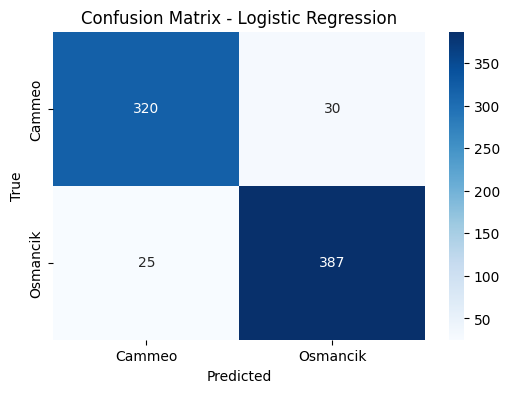

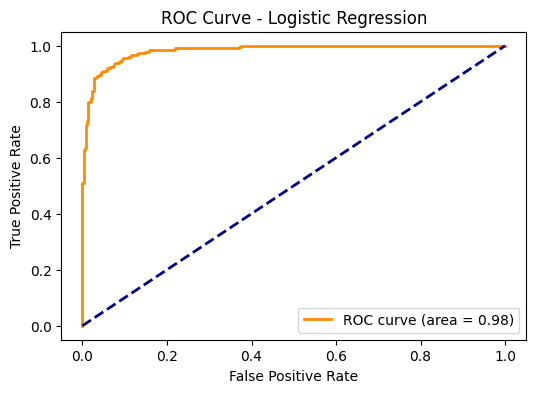

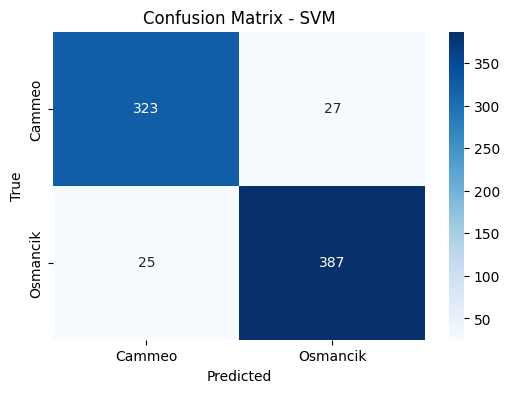

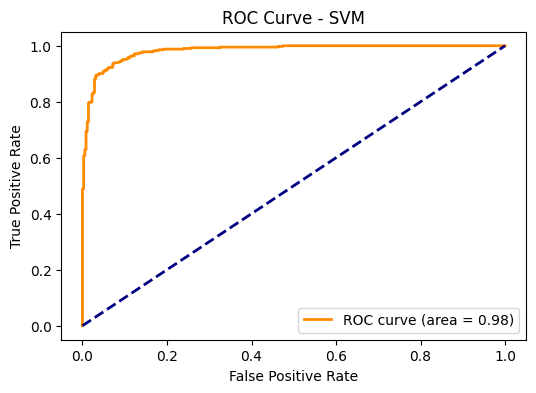

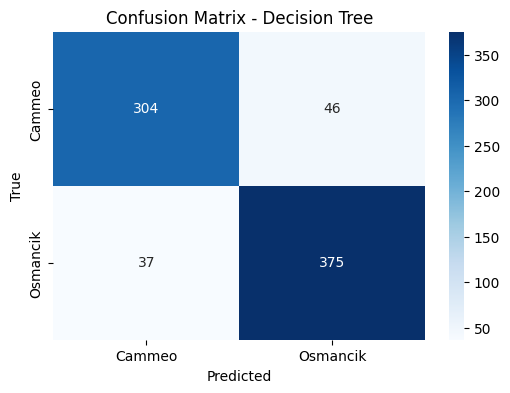

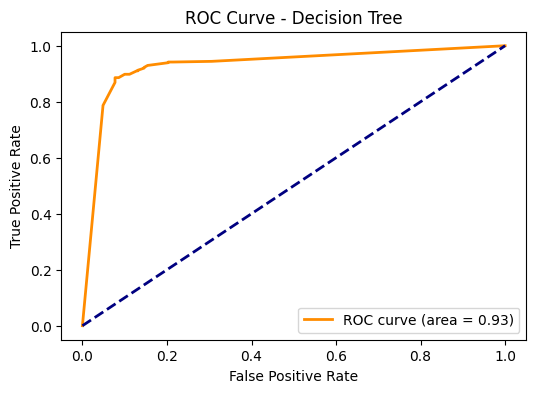

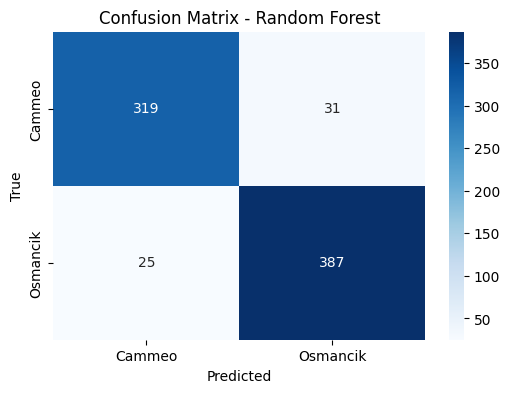

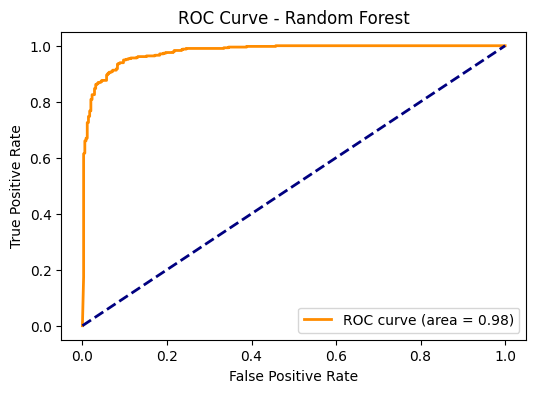

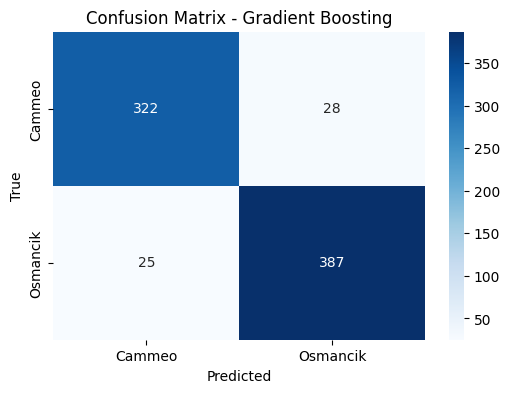

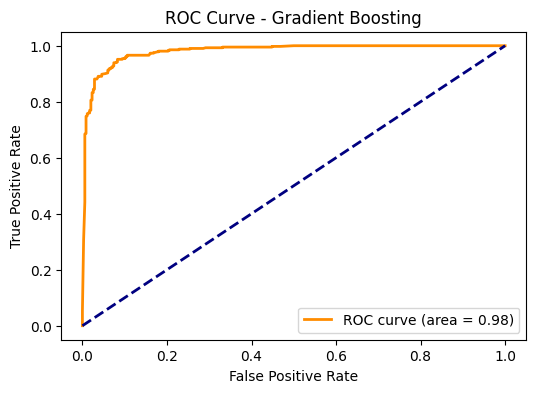

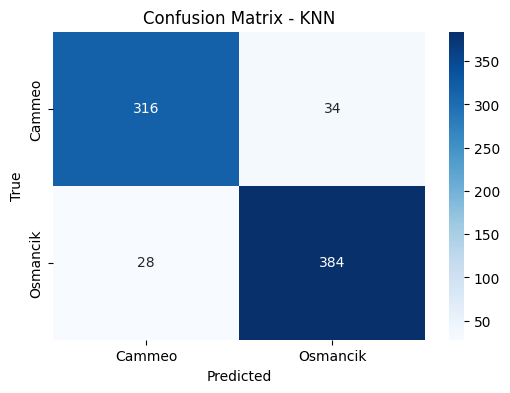

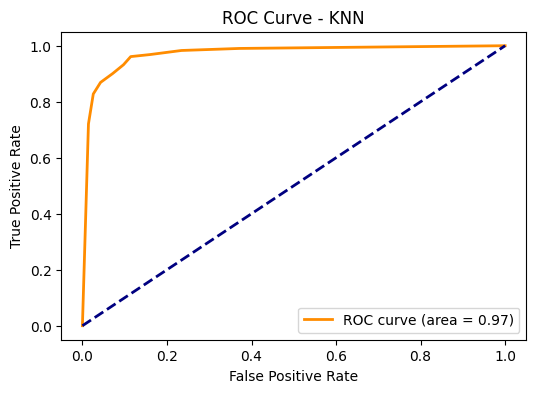

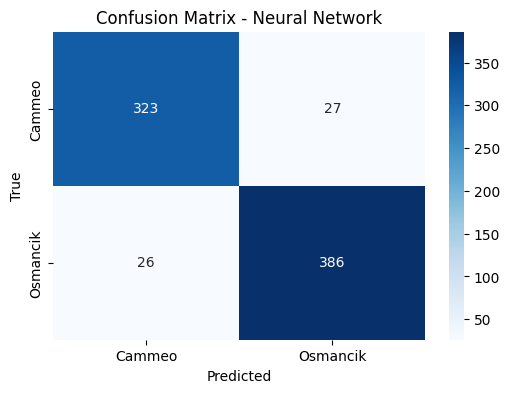

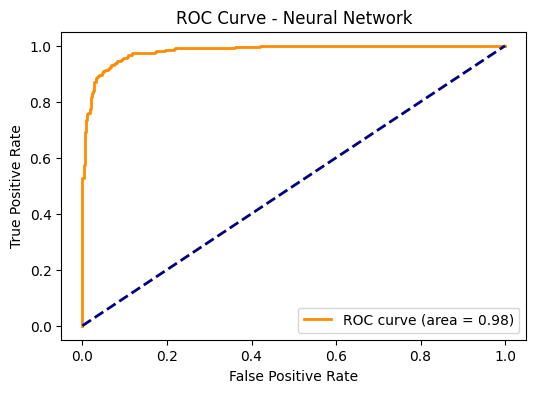

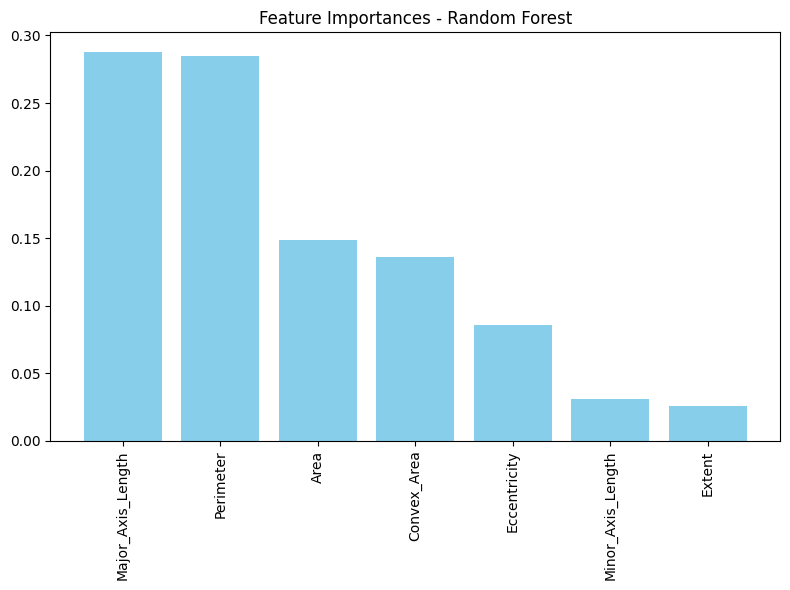

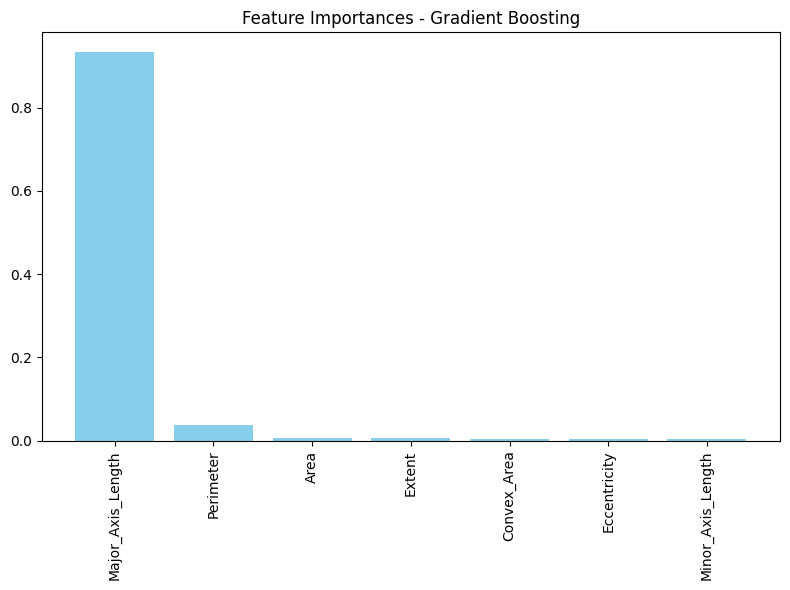

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_proba, model_name):
    """Plot the ROC curve."""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate and plot metrics for each tuned model
for model_name, model in tuned_models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, model_name)

    # ROC Curve
    if y_proba is not None:
        plot_roc_curve(y_test, y_proba, model_name)

# Feature Importance Plot for Tree-based Models
tree_based_models = ['Random Forest', 'Gradient Boosting']
for model_name in tree_based_models:
    if model_name in tuned_models:
        model = tuned_models[model_name]
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]

            plt.figure(figsize=(8, 6))
            plt.bar(range(X.shape[1]), importances[indices], align='center', color='skyblue')
            plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
            plt.title(f'Feature Importances - {model_name}')
            plt.tight_layout()
            plt.show()
